In [2]:
import scipy.integrate as integrate
from scipy.special import roots_legendre
import numpy as np
import numpy.linalg as lin
import matplotlib.pyplot as plt
from pandas import DataFrame
from sympy import symbols, solve

In [3]:
%matplotlib inline
plt.style.use("seaborn")
plt.rc('figure', figsize=(10, 10))

In [12]:
def local_max_min(func, a, b, max=True):
    """Return the local maximum or minimum 
    of the given function on the segment [a, b]
    """    
    x = symbols('x')    
    extrems = solve(func(x).diff(), x)
    possible_vals = [func(a), func(b)]
    for extremum in extrems:
        ext = float(extremum)            
        if b > ext > a:
            possible_vals.append(func(ext))
    return np.max(possible_vals) if max else np.min(possible_vals)

def print_results(n, res, act_res):
    """Print a pretty form of the functions result"""    
    print(f"Number of nodes: {n}")
    print(f"Value: {res}")
    print(f"Absolute error: {np.abs(act_res - res)}")
    print(f"Relative error: {np.abs((act_res - res) / act_res)}")

# Task 1
## $\int\limits_1^2{\frac{xdx}{(x^2 + 4)^2}}\\F(x) = -\frac{1}{2(x^2 + 4)}$

In [7]:
def F(x):
    return -1 / (2*(x**2 + 4))

def f(x):
    return x / (x**2 + 4)**2

def df(x):
    return (4 - 3*(x**2)) / (x**2  +4)**3

def d2f(x):
    return 12 * x * (x**2 - 4) / (x**2 + 4)**4

A = 1
B = 2

## Graph

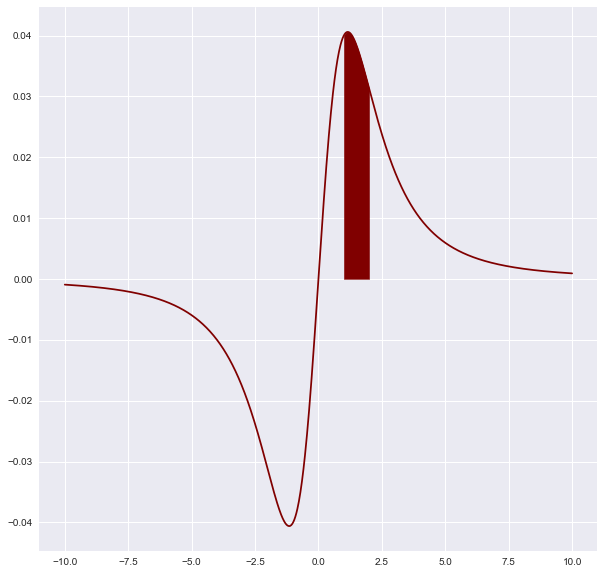

In [8]:
X = np.linspace(-10, 10, 1000)
X_A_B = np.linspace(A, B, 1000)
plt.plot(X, f(X), c="maroon")

plt.fill_between(X_A_B, f(X_A_B), color="maroon")

## Accurate value of the integral
### F(2) - F(1)

In [9]:
result = F(B) - F(A)
result

0.037500000000000006

## Left rectangles method

In [10]:
def left_rectangles(f, df, a, b, tol):
    """Compute the definite integral of the function
    using left rectangles method
    """
    # Number of nodes to achieve given accuracy
    n = int((b-a)**2 
            * np.abs(local_max_min(df, a, b) 
            / tol)) + 1
    h = (b-a) / n
    x = np.linspace(a, b, n + 1)
    return n, np.sum(f(x)) * h

## $\varepsilon = 10^{-5}$

In [13]:
n_5, res_5 = left_rectangles(f, df, A, B, 1e-5)
print_results(n_5, res_5, result)

Number of nodes: 801
Value: 0.037544472586935045
Absolute error: 4.447258693503903e-05
Relative error: 0.0011859356516010406


## $\varepsilon = 10^{-6}$

In [14]:
n_6, res_6 = left_rectangles(d, df, A, B, 1e-6)
print_results(n_6, res_6, result)

Number of nodes: 8001
Value: 0.03750445253767491
Absolute error: 4.452537674906609e-06
Relative error: 0.00011873433799750956


## Trapezoidal rule

In [19]:
def trapezoidal_rule(f, d2f, a, b, tol, maxiter=100):
    """Compute the definite integral of the function
    using trapezoidal rule with Runge rule if required
    to achieve given accuracy
    """
    d2f_max = local_max_min(d2f, a, b)
    # Number of nodes to achieve given accuracy    
    n = int(np.sqrt((b-a)**3 
                    * np.abs(d2f_max) 
                    / (6*tol))) + 1
    h = (b-a) / n
    x = np.linspace(a, b, n + 1)
    f_sum = f(x[0]) + 2*np.sum(f(x[1:-1])) + f(x[-1])
    J = h / 2 * f_sum
    if d2f_max == 0:
        for i in range(maxiter):
            h /= 2
            n = int((b-a) / h)
            x = np.linspace(a, b, n + 1)            
            f_sum = f(x[0]) \
                    + 2*np.sum(f(x[1:-1])) \
                    + f(x[-1])
            J2 = h / 2 * f_sum
            if np.abs(J2-J) / 3 <= tol:
                return n, J2
            J = J2
    return  n, J

## $\varepsilon = 10^{-5}$

In [20]:
n_5, res_5 = trapezoidal_rule(f, d2f, A, B, 1e-5)
print_results(n_5, res_5, result)

Number of nodes: 16
Value: 0.037492310621267635
Absolute error: 7.689378732370078e-06
Relative error: 0.00020505009952986872


## $\varepsilon = 10^{-6}$

In [21]:
n_6, res_6 = trapezoidal_rule(f, d2f, A, B, 1e-6)
print_results(n_6, res_6, result)

Number of nodes: 64
Value: 0.03749951935224457
Absolute error: 4.806477554367139e-07
Relative error: 1.281727347831237e-05


## Simpson's rule

In [22]:
def simpsons_rule(f, a, b, tol, maxiter=100):
    """Compute the definite integral of the function
    using Simpson's rule with Runge rule 
    to achieve given accuracy
    """
    h = b - a
    # Number of nodes to achieve given accuracy 
    n = 1 / 2
    x = np.linspace(a, b, 2)
    f_sum = f(x[0]) + f(x[1])
    J = h / 3 * f_sum
    for i in range(maxiter):
        h /= 2
        n = int((b-a) / (2*h))
        x = np.linspace(a, b, 2*n + 1)
        f_sum = f(x[0]) \
                + f(x[2*n]) \
                + 4*np.sum(f(x[1 : 2*n : 2])) \
                + 2*np.sum(f(x[2 : 2*n : 2])) 
        J2 = h / 3 * f_sum
        if np.abs(J2-J) / 15 < tol:
            return 2*n + 1, J2
        J = J2
    return  2*n + 1, J

## $\varepsilon = 10^{-5}$

In [23]:
n_5, res_5 = simpsons_rule(f, A, B, 1e-5)
print_results(n_5, res_5, result)

Number of nodes: 5
Value: 0.03749880364766115
Absolute error: 1.1963523388544561e-06
Relative error: 3.190272903611883e-05


## $\varepsilon = 10^{-6}$

In [24]:
n_6, res_6 = simpsons_rule(f, A, B, 1e-6)
print_results(n_6, res_6, result)

Number of nodes: 9
Value: 0.03749993097561172
Absolute error: 6.902438828837454e-08
Relative error: 1.8406503543566541e-06


# Task 2
## $\int\limits_{1.1}^{2.9}{\frac{1 + 0.4x^2}{0.7 + \sqrt{1.1x^2 + 1.2}}dx}$

In [25]:
def f2(x):
    return (1 + 0.4*(x**2)) / (0.7 + np.sqrt(1.1*x**2 + 1.2))

A2 = 1.1
B2 = 2.9

## Graph

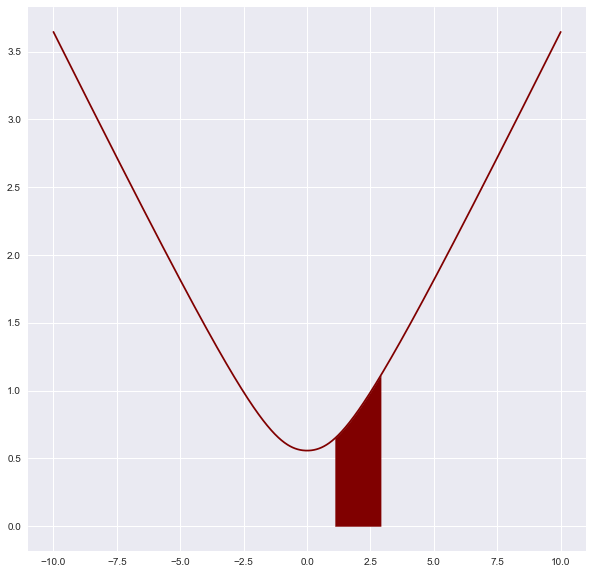

In [26]:
X_A_B = np.linspace(A2, B2, 1000)
plt.plot(X, f2(X), c="maroon")

plt.fill_between(X_A_B, f2(X_A_B), color="maroon")

## Accurate value of the integral
### scipy.integrate.quad

In [27]:
result2, _ = integrate.quad(f2, A2, B2)
result2

1.544386690112345

## Newton–Cotes rule

In [28]:
def newton_cotes(f, a, b, tol, maxiter=100):
    """Compute the definite integral of the function
    using Newton-Cotes rule with Runge rule 
    to achieve given accuracy
    """
    h = b - a
    J = 0   
    for i in range(maxiter):
        n = int((b-a) / h)
        x = np.linspace(a, b, n + 1)        
        H = integrate.newton_cotes(n)[0] / n
        J2 = (b-a) * np.sum(H*f(x))
        if np.abs(J-J2) < tol:
            return n + 1, J2
        h /= 2
        J = J2
    return 1, J

## $\varepsilon = 10^{-5}$

In [29]:
n_5, res_5 = newton_cotes(f2, A2, B2, 1e-5)
print_results(n_5, res_5, result2)

Number of nodes: 9
Value: 1.544386690203755
Absolute error: 9.140999068790734e-11
Relative error: 5.918853825479277e-11


## $\varepsilon = 10^{-6}$

In [30]:
n_6, res_6 = newton_cotes(f2, A2, B2, 1e-6)
print_results(n_6, res_6, result2)

Number of nodes: 17
Value: 1.5443866901006449
Absolute error: 1.1700196367314675e-11
Relative error: 7.575950014476978e-12


# Task 3
## $\int\limits_{0.2}^{1.11}{\frac{\sqrt{x^2 + 1}}{2x + 2.5}dx}$

In [31]:
def f3(x):
    return np.sqrt(x**2 + 1) / (2*x + 2.5)

A3 = 0.2
B3 = 1.11

## Graph

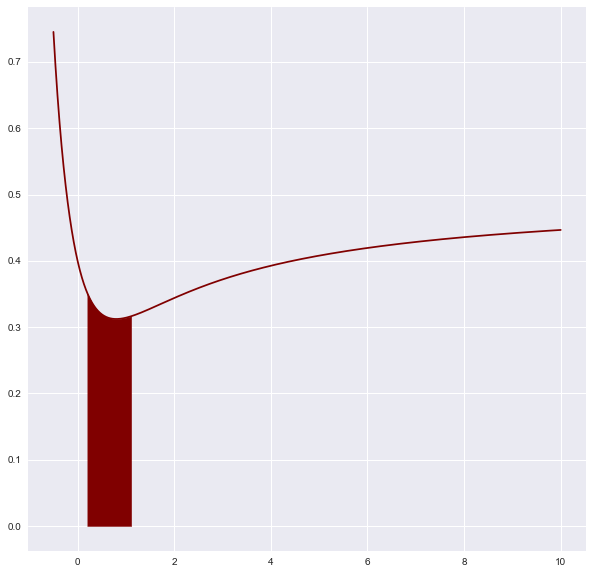

In [32]:
X = np.linspace(-0.5, 10, 1000)
X_A_B = np.linspace(A3, B3, 1000)
plt.plot(X, f3(X), c="maroon")

plt.fill_between(X_A_B, f3(X_A_B), color="maroon")

## Accurate value of the integral
### scipy.integrate.quad

In [33]:
result3, _ = integrate.quad(f3, A3, B3)
result3

0.2914236606111758

## Chebyshev quadrature for number of nodes 5 and 6

In [34]:
def chebyshev(f, a, b, n):
    """Compute the definite integral of the function
    using Chebyshev quadrature with 5 or 6 nodes
    """
    if n == 5:
        t = np.array([-0.832498, -0.374513, 
                   0, 0.374513, 0.832498])
    elif n == 6:
        t = np.array([-0.866247, -0.422519, -0.266635, 
                   0.266635, 0.422519, 0.866247])
    else:
        raise ValueError("Wrong value of n parameter")
    x = (b+a)/2 + (b-a)*t/2
    return (b-a) / n * np.sum(f(x))

In [35]:
res_5 = chebyshev(f3, A3, B3, 5)
res_6 = chebyshev(f3, A3, B3, 6)
print_results(5, res_5, result3)
print()
print_results(6, res_6, result3)

Number of nodes: 5
Value: 0.29142315105104466
Absolute error: 5.095601311455589e-07
Relative error: 1.7485201101273166e-06

Number of nodes: 6
Value: 0.2914236451084485
Absolute error: 1.5502727324090415e-08
Relative error: 5.319652938123824e-08


## Gauss quadrature

In [36]:
def gauss(f, a, b, n):
    """Compute the definite integral of the function
    using Gauss quadrature
    """
    t, c = roots_legendre(n)
    x = (b+a)/2 + (b-a)*t/2
    return (b-a) / 2 * np.sum(c*f(x))

In [37]:
res_5 = gauss(f3, A3, B3, 5)
res_6 = gauss(f3, A3, B3, 6)
print_results(5, res_5, result3)
print()
print_results(6, res_6, result3)

Number of nodes: 5
Value: 0.2914236595614204
Absolute error: 1.0497553937227622e-09
Relative error: 3.6021625406846086e-09

Number of nodes: 6
Value: 0.2914236606176464
Absolute error: 6.470601832120337e-12
Relative error: 2.2203419648734575e-11
